In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from PIL import Image
from IPython.display import display
import textdistance

from data_preprocess import preprocessing

In [43]:
class SEARCH_RECOMMEND:
    
    def __init__(self, df, qval=None):
        self.df = df
        self.qval = qval
        self.df_ = self.preprocess_df(self.df)
    
    def preprocess_df(self, df):
        # make new-tag
        df['new_tag'] = list(
        zip(
            df['top3_style'].tolist(), 
            df['tags'].tolist(),
            df['name'].tolist(),
            df['projectId'].tolist()
            )
        )

        df['new_tag'] = df['new_tag'].apply(self.reduce_newtag)
        df['new_tag'] = df['new_tag'].apply(lambda x: ' '.join(x).lower())
        return df
    
    def reduce_newtag(self, x):
        newtag = []
        for tag in x:
            if type(tag) == str:
                newtag.append(tag)
            else:
                newtag.extend(tag)
        return newtag

    def search_product(self, prod, topn=10, algo='sorensen'):
        
        # declare id of searching product
        id_ = self.df_[self.df_['name'] == prod]['product_id'].values[0]
        
        # search product tag from input product name
        search_prod_tag = self.df_[self.df_['name'] == prod].sort_values(by='awesome_score', ascending=False)['new_tag'].values[0]

        # calculate similarity
        sim_score = []
        import time
        new_tag = self.df_['new_tag'].tolist()
        start_time = time.time()
        for i, tag in enumerate(new_tag):
            if algo == 'sorensen':
                sim_score.append(textdistance.Sorensen(qval=self.qval, as_set=True).normalized_similarity(search_prod_tag, tag))
            elif algo == 'ncd':
                sim_score.append(textdistance.EntropyNCD(qval=self.qval).normalized_similarity(search_prod_tag, tag))
                

        print(f'검색어 : {search_prod_tag}')
        print(f'검색 시간 : {round(time.time()-start_time, 4)}초')

        # save result
        sim_score = np.asarray(sim_score)
        sim_score_idx = np.arange(len(sim_score))

        result_df = self.df_.iloc[sim_score_idx][['product_id', 'name', 'new_tag', 'projectId', 'images']]
        result_df['similarity'] = sim_score
        result_df = result_df[result_df['product_id']!=id_]
        result_df = result_df.drop_duplicates(['product_id'])
        result_df = result_df.sort_values(by='similarity', ascending=False).reset_index()[:topn]
        
        # show result image
        print(f'사용자가 선택한 아이템 : {prod}')
        try:
            prod_res = requests.get(self.df_[self.df_['name'] == prod]['images'].values[0][0])
            display(Image.open(BytesIO(prod_res.content)))
        except:
            print('이미지 없음\n')
            print()

        print("="*80)
        print(f"추천 아이템 Top{topn}")
        print("="*80)
        
        i = 1
        for name, img_url in result_df[['name', 'images']].values:
            print(f"추천 {i}순위 : {name}")
            try:
                res = requests.get(img_url[0])
                img = Image.open(BytesIO(res.content))
                display(img)
            except:
                print('이미지 없음\n')
            print("-"*60)
            i += 10

        self.result = result_df

In [20]:
base_path = '2022-03-07/'
file_paths = [
    base_path + 'bestshots.json', 
    base_path + 'items.json', 
    base_path +'categories.json', 
    base_path +'products.json'
]

In [21]:
products_df_4, products_df_b = preprocessing(file_paths)
products_df_4.shape, products_df_b.shape

/Users/ruo/Desktop/codestates/CP2/data_preprocess.py:37: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  items_stack = pd.DataFrame(templates_df['items'].apply(lambda x: pd.Series(x)).stack()).reset_index(1, drop=True)


((4211, 10), (46576, 10))

In [44]:
search_engine_b = SEARCH_RECOMMEND(products_df_b, qval=3)

검색어 : natural mid_century_modern modern 커튼 데코뷰 화이트 쉬폰 화이트 쉬폰 커튼 화이트 x9djpepd57a2bdcd418437c
검색 시간 : 2.7189초
사용자가 선택한 아이템 : 화이트 쉬폰 커튼 화이트


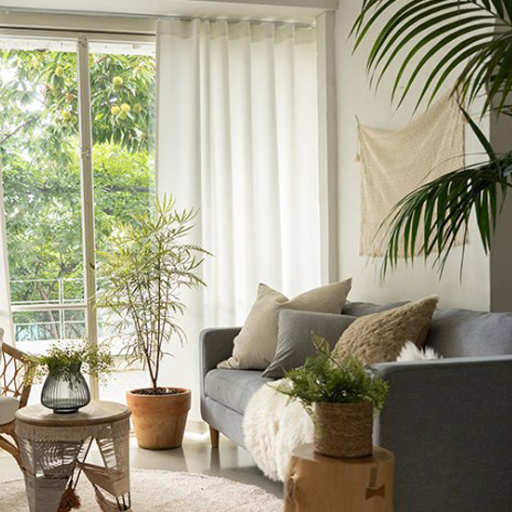

추천 아이템 Top10
추천 1순위 : 특대형 아레카야자 흰색 데코 화분 (화이트)


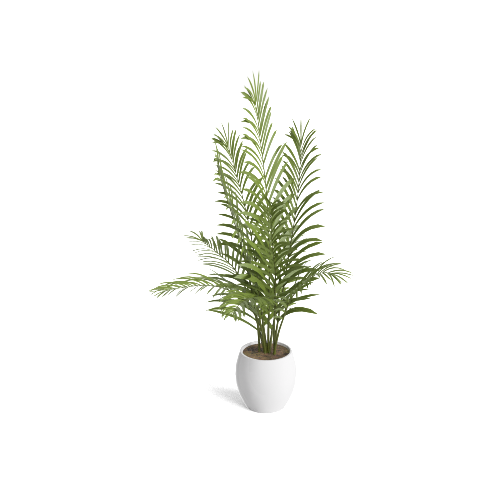

------------------------------------------------------------
추천 11순위 : 혼요 오가닉코팅 디지털 에어프라이어 (화이트)


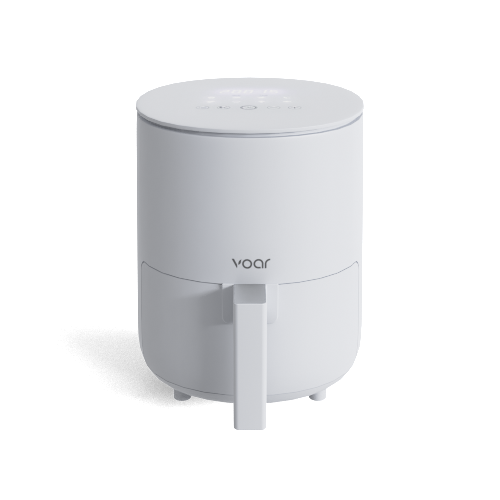

------------------------------------------------------------
추천 21순위 : 유럽인기 라탄바구니 2XL


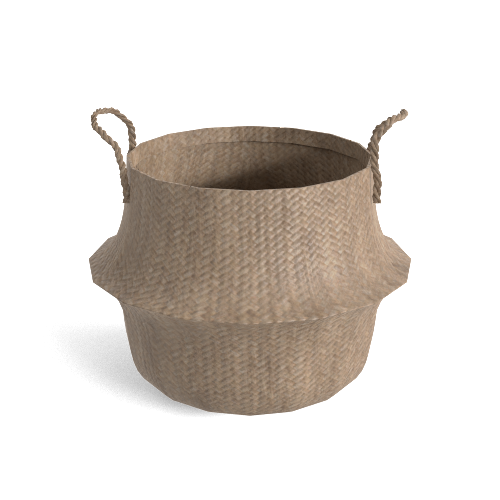

------------------------------------------------------------
추천 31순위 : 와이드 원목 수납선반 5단


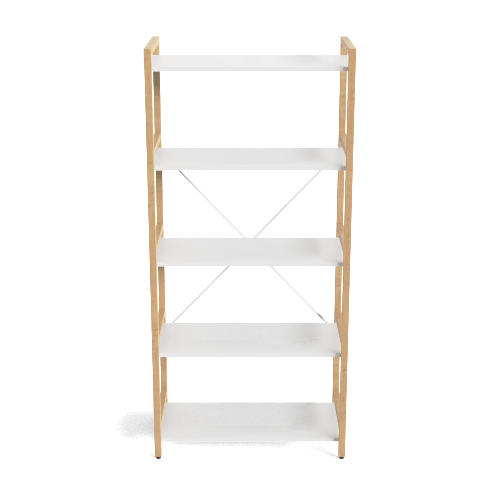

------------------------------------------------------------
추천 41순위 : 카페 패브릭 접이식 소파베드 (베이지)


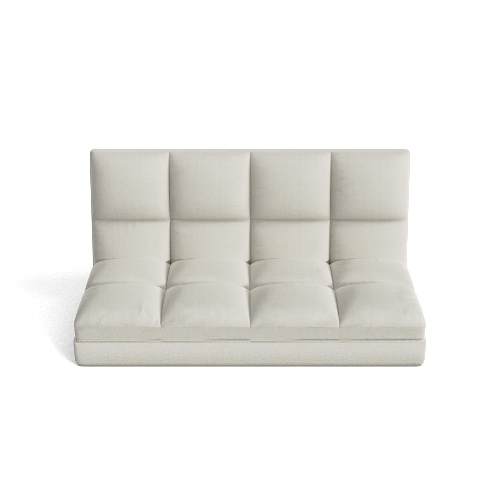

------------------------------------------------------------
추천 51순위 : 원목 코너형 4단 선반 (내추럴)


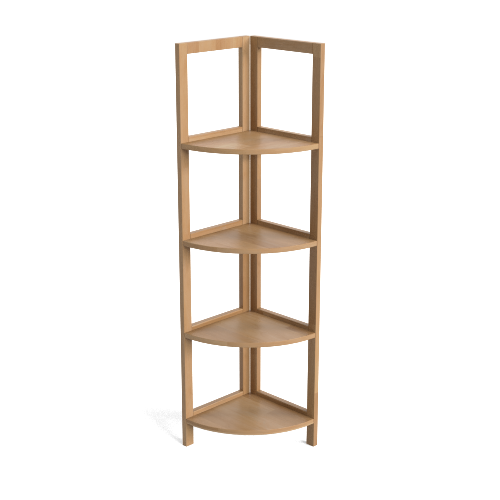

------------------------------------------------------------
추천 61순위 : 뉴시나몬 윈저 체어 B형 (라이트브라운)


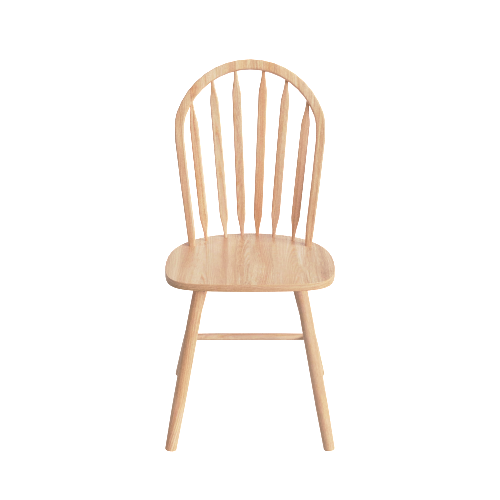

------------------------------------------------------------
추천 71순위 : 뉴시나몬 윈저 체어 A형 (라이트브라운)


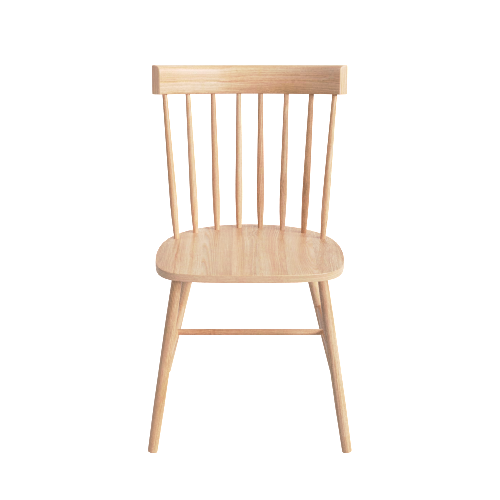

------------------------------------------------------------
추천 81순위 : 인테리어 포스터 Light, Life, Us no.4 (50x70 화이트)


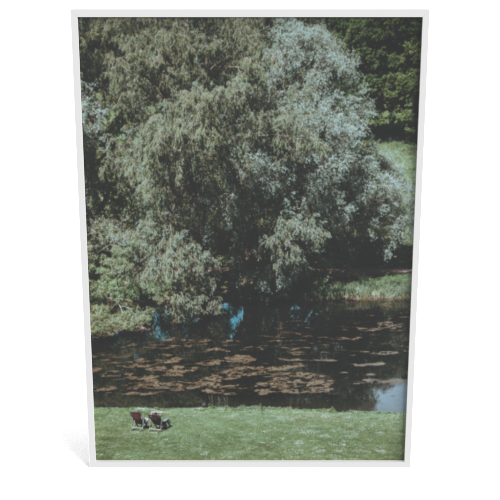

------------------------------------------------------------
추천 91순위 : NEW 린넨스타일 암막커튼 (아이보리)


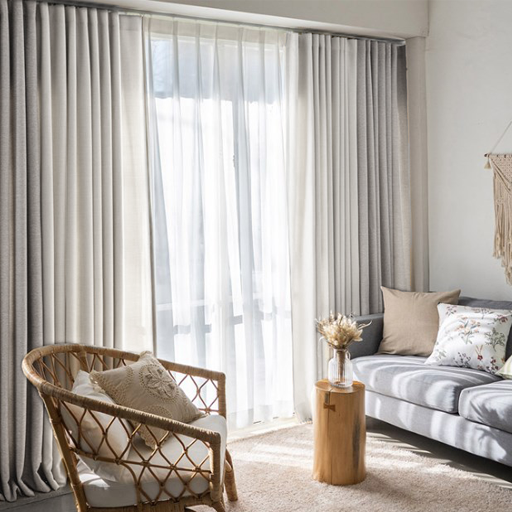

------------------------------------------------------------


In [45]:
prod = "화이트 쉬폰 커튼 화이트"
search_engine_b.search_product(prod, topn=10)

In [46]:
search_engine_b.result

,index,product_id,name,new_tag,projectId,images,similarity
0,215,XVFHlhG52AC559F0BA54F3F,특대형 아레카야자 흰색 데코 화분 (화이트),natural mid_century_modern modern 특대형 아레카야자 흰색...,X9djPepD57A2BDCD418437C,[https://resources.archisketch.com/product/XVF...,0.714286
1,318,Xz-wAFH5EEE0C92D4B44767,혼요 오가닉코팅 디지털 에어프라이어 (화이트),natural mid_century_modern modern 보아르 혼요 오가닉코팅...,X9djPepD57A2BDCD418437C,[https://resources.archisketch.com/product/Xz-...,0.675862
2,301,XxzIVRl47A310D4F5EB4075,유럽인기 라탄바구니 2XL,natural mid_century_modern modern 인테리어소품 인테리어 ...,X9djPepD57A2BDCD418437C,[https://resources.archisketch.com/product/Xxz...,0.653333
3,205,XZvSCSS8CD1831D050045BB,와이드 원목 수납선반 5단,natural mid_century_modern modern 선반 스탠드선반 선반장...,X9djPepD57A2BDCD418437C,[https://resources.archisketch.com/product/XZv...,0.579545
4,198,68787D99716C4340,카페 패브릭 접이식 소파베드 (베이지),natural mid_century_modern modern 소파 쇼파 소파베드 쇼...,X9djPepD57A2BDCD418437C,[https://resources.archisketch.com/product/687...,0.536313
5,336,XZqdP8rF328DB2EB2204A20,원목 코너형 4단 선반 (내추럴),natural mid_century_modern modern 선반 스탠드선반 선반장...,X9djPepD57A2BDCD418437C,[https://resources.archisketch.com/product/XZq...,0.536313
6,10,XrTVBz466807713843D41CB,뉴시나몬 윈저 체어 B형 (라이트브라운),natural mid_century_modern modern 일반의자 식탁의자 인테...,X9djPepD57A2BDCD418437C,[https://resources.archisketch.com/product/XrT...,0.510638
7,343,XrTVBzr2F846AF2835B4DF8,뉴시나몬 윈저 체어 A형 (라이트브라운),natural mid_century_modern modern 일반의자 식탁의자 인테...,X9djPepD57A2BDCD418437C,[https://resources.archisketch.com/product/XrT...,0.505263
8,309,XkcVzwM5BEDBE9E76A74BF5,"인테리어 포스터 Light, Life, Us no.4 (50x70 화이트)",natural mid_century_modern modern 홈갤러리 갤러리 미술품...,X9djPepD57A2BDCD418437C,[https://resources.archisketch.com/product/Xkc...,0.500000
9,13654,18089A2DB64C429F,NEW 린넨스타일 암막커튼 (아이보리),natural mid_century_modern modern 커튼 데코뷰 린넨스타일...,X9XsXFC1E0A0F5CA1394594,[https://resources.archisketch.com/product/180...,0.496644
